# UCML DATASET

## Loading Data and Labels

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import os
import torch
from torchvision import datasets, transforms

data_dir = "datasets/UCMerced_LandUse/Images"
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Decide on the ratio of train/val/test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)


print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Train dataset: {train_dataset[0]}")

Train dataset size: 1470
Val dataset size: 315
Test dataset size: 315
Train dataset: (tensor([[[0.2157, 0.2314, 0.2314,  ..., 0.1490, 0.1451, 0.1333],
         [0.2196, 0.2314, 0.2314,  ..., 0.1922, 0.2039, 0.2078],
         [0.2314, 0.2314, 0.2039,  ..., 0.2510, 0.2941, 0.3216],
         ...,
         [0.2039, 0.2902, 0.3294,  ..., 0.7882, 0.7961, 0.7961],
         [0.2078, 0.2824, 0.3216,  ..., 0.7804, 0.7765, 0.7686],
         [0.1765, 0.2510, 0.2784,  ..., 0.7294, 0.6941, 0.6980]],

        [[0.2824, 0.2784, 0.2824,  ..., 0.1255, 0.0980, 0.0980],
         [0.2667, 0.2706, 0.2667,  ..., 0.2157, 0.2157, 0.1804],
         [0.2667, 0.2588, 0.2471,  ..., 0.2549, 0.2941, 0.3137],
         ...,
         [0.2039, 0.3020, 0.3373,  ..., 0.8157, 0.8196, 0.8235],
         [0.1882, 0.2941, 0.3333,  ..., 0.8157, 0.8078, 0.8039],
         [0.1804, 0.2627, 0.2824,  ..., 0.7843, 0.7490, 0.7451]],

        [[0.2706, 0.2745, 0.2745,  ..., 0.2588, 0.2706, 0.2549],
         [0.2745, 0.2745, 0.2824,  ..

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # Common augmentations for aerial imagery
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    # Optionally, you can add normalization 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
batch_size = 16

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 21  # UC Merced has 21 classes



In [6]:
criterion = nn.CrossEntropyLoss()

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)


/home/melihkaan/Desktop/vision/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/melihkaan/Desktop/vision/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)



In [8]:
import optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    momentum = trial.suggest_float("momentum", 0.5, 0.99)

    # Create model again for each trial
    model_ = models.resnet50(pretrained=True)
    model_.fc = nn.Linear(model_.fc.in_features, num_classes)
    model_.to(device)

    # Choose an optimizer based on the suggestion
    if optimizer_name == "Adam":
        opt = torch.optim.Adam(model_.parameters(), lr=lr)
    else:  # SGD
        opt = torch.optim.SGD(model_.parameters(), lr=lr, momentum=momentum)

    # Training loop (small number of epochs for demonstration)
    max_epochs = 3
    for epoch in range(max_epochs):
        model_.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            opt.zero_grad()
            outputs = model_(images)
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

        # Validation to measure accuracy
        model_.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        
        # Report validation accuracy to optuna
        trial.report(val_accuracy, epoch)

        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


/home/melihkaan/Desktop/vision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-13 14:23:11,641] A new study created in memory with name: no-name-9f665b7d-e397-4c38-8605-d1f38d6cfb4e
/tmp/ipykernel_6297/1602609386.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/home/melihkaan/Desktop/vision/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/melihkaan/Desktop/vision/.venv/lib/python3.12/site-packages/torchvision

In [9]:
print("Best trial:")
best_trial = study.best_trial
print(f"\tValue (Accuracy): {best_trial.value}")
print("\tParams: ")
for key, value in best_trial.params.items():
    print(f"\t\t{key}: {value}")


Best trial:
	Value (Accuracy): 0.9746031746031746
	Params: 
		lr: 2.0956418839800188e-05
		optimizer: Adam
		momentum: 0.5887438434076424


In [16]:
import matplotlib.pyplot as plt
import csv
import copy
import xlsxwriter

def train_model(model, criterion, optimizer, num_epochs=25, patience=5):

    csv_file = open('metrics_log.csv', 'w', newline='')
    writer = csv.writer(csv_file)

    # Write a header row
    writer.writerow(['Epoch', 'TrainLoss', 'ValLoss', 'TrainAcc', 'ValAcc'])

    workbook = xlsxwriter.Workbook('metrics_log.xlsx')
    worksheet = workbook.add_worksheet('Metrics')
    
    # Write headers
    headers = ['Epoch', 'TrainLoss', 'ValLoss', 'TrainAcc', 'ValAcc']
    for col, header in enumerate(headers):
        worksheet.write(0, col, header)




    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    
    # Lists to store results for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        ###################
        # Training phase
        ###################
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item() * images.size(0)

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        ###################
        # Validation phase
        ###################
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val

        # Print epoch results
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")

        # Append for plotting
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        writer.writerow([epoch+1, epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc])

        # Early stopping check
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)


    # Write data
    for row in range(len(train_losses)):
        worksheet.write(row+1, 0, row+1)  # Epoch
        worksheet.write(row+1, 1, train_losses[row])
        worksheet.write(row+1, 2, val_losses[row])
        worksheet.write(row+1, 3, train_accuracies[row])
        worksheet.write(row+1, 4, val_accuracies[row])
    
    # Create a chart for Loss
    chart_loss = workbook.add_chart({'type': 'line'})
    # Add series for TrainLoss (column 1)
    chart_loss.add_series({
        'name': 'TrainLoss',
        'categories': ['Metrics', 1, 0, len(train_losses), 0],  # epoch numbers
        'values': ['Metrics', 1, 1, len(train_losses), 1],      # train loss
    })
    # Add series for ValLoss (column 2)
    chart_loss.add_series({
        'name': 'ValLoss',
        'categories': ['Metrics', 1, 0, len(train_losses), 0],
        'values': ['Metrics', 1, 2, len(train_losses), 2],
    })
    chart_loss.set_title({'name': 'Loss over Epochs'})
    chart_loss.set_x_axis({'name': 'Epoch'})
    chart_loss.set_y_axis({'name': 'Loss'})
    
    # Insert chart into the worksheet
    worksheet.insert_chart('G2', chart_loss)
    
    # Create a chart for Accuracy
    chart_acc = workbook.add_chart({'type': 'line'})
    # Add series for TrainAcc (column 3)
    chart_acc.add_series({
        'name': 'TrainAcc',
        'categories': ['Metrics', 1, 0, len(train_losses), 0],  # epoch
        'values': ['Metrics', 1, 3, len(train_losses), 3],      # train acc
    })
    # Add series for ValAcc (column 4)
    chart_acc.add_series({
        'name': 'ValAcc',
        'categories': ['Metrics', 1, 0, len(train_losses), 0],
        'values': ['Metrics', 1, 4, len(train_losses), 4],
    })
    chart_acc.set_title({'name': 'Accuracy over Epochs'})
    chart_acc.set_x_axis({'name': 'Epoch'})
    chart_acc.set_y_axis({'name': 'Accuracy'})

    worksheet.insert_chart('G18', chart_acc)
    
    workbook.close()

    csv_file.close()

    # After training finishes, plot the results
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Acc')
    plt.plot(epochs_range, val_accuracies, label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, best_acc

Epoch 1/25
Train Loss: 0.0365, Train Acc: 0.9980
Val Loss:   0.0501, Val Acc:   0.9810
Epoch 2/25
Train Loss: 0.0214, Train Acc: 0.9993
Val Loss:   0.0402, Val Acc:   0.9873
Epoch 3/25
Train Loss: 0.0308, Train Acc: 0.9952
Val Loss:   0.0529, Val Acc:   0.9810
Epoch 4/25
Train Loss: 0.0191, Train Acc: 0.9980
Val Loss:   0.0428, Val Acc:   0.9841
Epoch 5/25
Train Loss: 0.0248, Train Acc: 0.9959
Val Loss:   0.0850, Val Acc:   0.9746
Epoch 6/25
Train Loss: 0.0187, Train Acc: 0.9973
Val Loss:   0.0616, Val Acc:   0.9778
Epoch 7/25
Train Loss: 0.0218, Train Acc: 0.9952
Val Loss:   0.0782, Val Acc:   0.9746
Early stopping triggered!


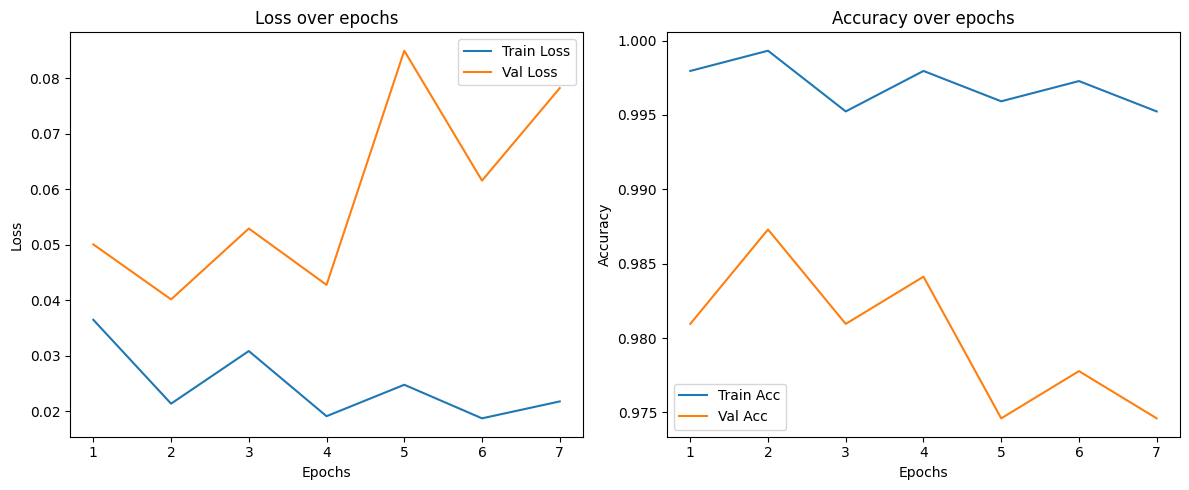

In [17]:
if best_trial.params["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params["lr"])
else:  # SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=best_trial.params["lr"], momentum=best_trial.params["momentum"])

model, best_val_acc = train_model(model, criterion, optimizer, num_epochs=25, patience=5)

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9778


: 